Random Forest Accuracy: 0.9147157190635451
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        57
           1       0.89      0.99      0.94      1115
           2       0.96      0.79      0.87       622

    accuracy                           0.91      1794
   macro avg       0.93      0.88      0.90      1794
weighted avg       0.92      0.91      0.91      1794



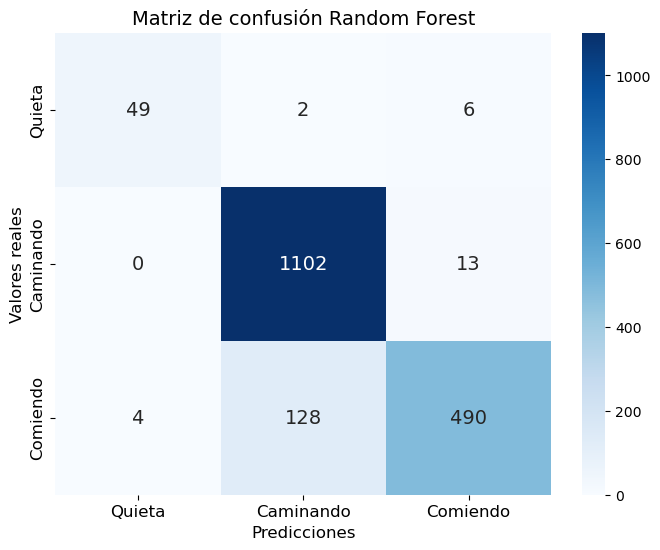

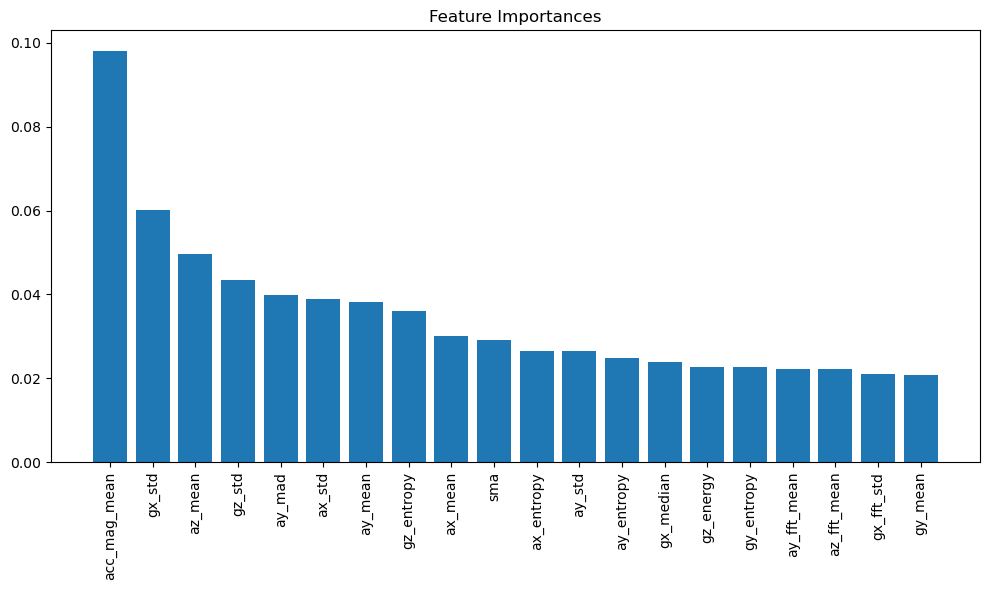

In [1]:
import sys
sys.path.append('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML')

import pandas as pd
import numpy as np
from src.preprocessing import calcular_static_dynamic, encode_labels
from src.features import create_windows, compute_features
from src.modeling import remove_correlated_features, tune_logistic_regression, tune_random_forest, tune_svm, tune_xgb, tune_voting, smote
from src.visualization import plot_confusion_matrix, plot_feature_importance
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data loading and preprocessing
data_train = pd.read_csv('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML/data/Archivos_CSV_con_etiquetas/Mix_Erika_Aria_Ingrid_T76train.csv')
data_test = pd.read_csv('C:/Users/carlo/Desktop/Tesis/Github/Predicciones_ML/data/Archivos_CSV_con_etiquetas/20-11-2025_T76_T5_test.csv')
data_train['dateTime_UTC'] = pd.to_datetime(data_train['dateTime_UTC'], errors='coerce')
data_test['dateTime_UTC'] = pd.to_datetime(data_test['dateTime_UTC'], errors='coerce')
df_train = data_train[data_train['dateTime_UTC'].notna()]
df_test = data_test[data_test['dateTime_UTC'].notna()]
df_train = df_train.sort_values(by=['dateTime_UTC'], ignore_index=True)
df_test = df_test.sort_values(by=['dateTime_UTC'], ignore_index=True)


# Windowing and feature extraction
window_size = 25
step_size = window_size//2
x_list_train, y_list_train, z_list_train, gx_list_train, gy_list_train, gz_list_train, train_labels = create_windows(df_train, window_size, step_size)
x_df_train = pd.DataFrame(x_list_train)
y_df_train = pd.DataFrame(y_list_train)
z_df_train = pd.DataFrame(z_list_train)
gx_df_train = pd.DataFrame(gx_list_train)
gy_df_train = pd.DataFrame(gy_list_train)
gz_df_train = pd.DataFrame(gz_list_train)
X_train = compute_features(x_df_train, y_df_train, z_df_train, gx_df_train, gy_df_train, gz_df_train, window_size)

x_list_test, y_list_test, z_list_test, gx_list_test, gy_list_test, gz_list_test, test_labels = create_windows(df_test, window_size, step_size)
x_df_test = pd.DataFrame(x_list_test)
y_df_test = pd.DataFrame(y_list_test)
z_df_test = pd.DataFrame(z_list_test)
gx_df_test = pd.DataFrame(gx_list_test)
gy_df_test = pd.DataFrame(gy_list_test)
gz_df_test = pd.DataFrame(gz_list_test)
X_test = compute_features(x_df_test, y_df_test, z_df_test, gx_df_test, gy_df_test, gz_df_test, window_size)

# Label encoding
diccionario_codificacion = {'Quieta': 0, 'Caminando': 1, 'Comiendo': 2}
train_labels = encode_labels(train_labels, diccionario_codificacion)
test_labels = encode_labels(test_labels, diccionario_codificacion)

# Feature selection (remove correlated features)
X_train_reduced, X_test_reduced, to_drop = remove_correlated_features(X_train, X_test, threshold=0.9)
# print(f"Features eliminadas por correlación > 0.9:\n{to_drop}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# #SMOTE (balancing the dataset)
# X_train_scaled, train_labels = smote(X_train_scaled, train_labels)

# Model training and hyperparameter tuning
# lr_best, lr_params = tune_logistic_regression(X_train_scaled, train_labels)
rf_best, rf_params = tune_random_forest(X_train_scaled, train_labels)
# svm_best, svm_params = tune_svm(X_train_scaled, train_labels)
# xgb_best, xgb_params = tune_xgb(X_train_scaled, train_labels)
# voting_clf= tune_voting(X_train_scaled, train_labels, base_models={'lr': lr_best, 'rf': rf_best, 'svm': svm_best, 'xgb': xgb_best})

import joblib
import os

# Guardar temporalmente el modelo
joblib.dump(rf_best, "modelo_tortugas_rf.pkl")

# Evaluation
# pred_lr = lr_best.predict(X_test_scaled)
pred_rf = rf_best.predict(X_test_scaled)
# pred_svm = svm_best.predict(X_test_scaled)
# pred_xgb = xgb_best.predict(X_test_scaled)
# pred_voting = voting_clf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, classification_report
# print("Logistic Regression Accuracy:", accuracy_score(test_labels, pred_lr))
# print(classification_report(test_labels, pred_lr))
print("Random Forest Accuracy:", accuracy_score(test_labels, pred_rf))
print(classification_report(test_labels, pred_rf))
# print("SVM Accuracy:", accuracy_score(test_labels, pred_svm))
# print(classification_report(test_labels, pred_svm))
# print("XGBoost Accuracy:", accuracy_score(test_labels, pred_xgb))
# print(classification_report(test_labels, pred_xgb))
# print("Voting Classifier Accuracy:", accuracy_score(test_labels, pred_voting))
# print(classification_report(test_labels, pred_voting))

# Confusion matrices
labels = list(diccionario_codificacion.keys())
# plot_confusion_matrix(test_labels, pred_lr, labels, "Matriz de confusión - Regresión Logística")
plot_confusion_matrix(test_labels, pred_rf, labels, "Matriz de confusión Random Forest")
# plot_confusion_matrix(test_labels, pred_svm, labels, "Matriz de confusión - SVM")
# plot_confusion_matrix(test_labels, pred_xgb, labels, "Matriz de confusión - XGBoost")
# plot_confusion_matrix(test_labels, pred_voting, labels, "Matriz de confusión - Voting Classifier")

plot_feature_importance(rf_best, X_train_reduced.columns)

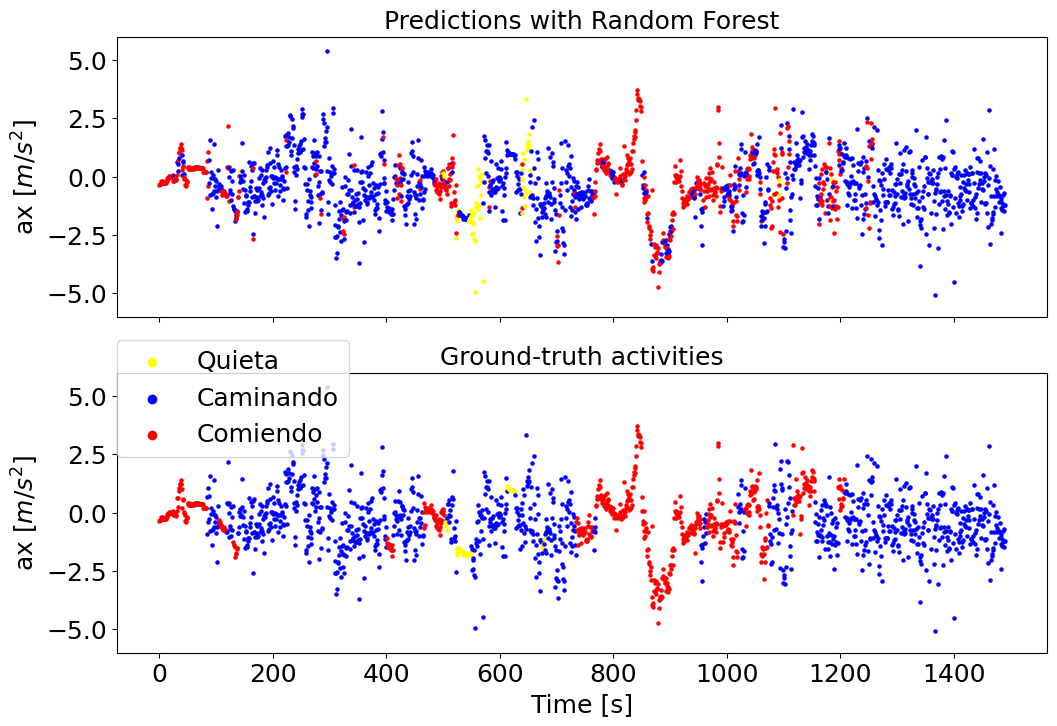

In [2]:
import matplotlib.pyplot as plt
import math
# Definir etiquetas y colores para las predicciones de RF con nombres de actividades
color_map = {
    'Quieta': 'yellow',
    'Caminando': 'blue',
    'Comiendo': 'red',
}

# Mapear los valores numéricos a nombres de actividades
label_mapping = {0: 'Quieta', 1: 'Caminando', 2: 'Comiendo'}

# Convertir predicciones numéricas en nombres de actividades
act_pred_rf_names = [label_mapping[label] for label in pred_rf]

# Generar colores para predicciones de RF usando los nombres de las actividades
colors_rf = [color_map[label] for label in act_pred_rf_names]

# Separar colores en pares e impares
colors_par = colors_rf[::2]
colors_impar = colors_rf[1::2]

# Generar colores para etiquetas reales en df_test
colores_verdaderos = [color_map[label] for label in df_test['Actividades']]

# Parámetros de la gráfica
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
size = 5
frec = 14.45354719
step = 12
N = len(df_test) 

# Iterar sobre los datos para graficar
for i in range(0, N, step):
    index = int(math.floor(i / window_size))

    # Evitar errores de índice
    color_par = colors_par[index] if index < len(colors_par) else 'black'
    color_impar = colors_impar[index] if index < len(colors_impar) else 'black'

    # Graficar predicciones de RF
    if index < len(colors_par) and index < len(colors_impar):
        if color_par == color_impar:
            ax1.scatter(i / frec, df_test.iloc[i]['ax'], color=color_par, s=size)
        else:
            ax1.scatter(i / frec, df_test.iloc[i]['ax'] + 0.1, color=color_par, s=size)
            ax1.scatter(i / frec, df_test.iloc[i]['ax'] - 0.1, color=color_impar, s=size)

    # Graficar etiquetas reales
    ax2.scatter(i / frec, df_test.iloc[i]['ax'], color=colores_verdaderos[i], s=size)


for esp, color in color_map.items():
    ax2.scatter([], [], color=color, label=label_mapping.get(esp, esp))
# for activity_name, color in color_map.items():
#     ax2.scatter([], [], color=color, label=activity_name)

# Configuración de títulos y etiquetas
ax1.set_title('Predictions with Random Forest', fontsize=18)
ax2.set_title('Ground-truth activities', fontsize=18)

ax1.set_ylabel('ax [$m/s^2$]', fontsize=18)
ax2.set_ylabel('ax [$m/s^2$]', fontsize=18)
ax2.set_xlabel('Time [s]', fontsize=18)

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

ax1.grid(False)
ax2.grid(False)
ax1.set_ylim(-6, 6)
ax2.set_ylim(-6, 6)

# Mostrar la leyenda con nombres de actividades
ax2.legend(loc=(0, 0.7), fontsize=18)

plt.show()